# Research Pricing Framework

## Overview 

DRAFT VERSION

Pricing involves evaluating the fair value price or forecasting the future price whenever an action is required. The examples shown so far have been based on fixed time intervals (i.e., a physical clock), meaning that the price is evaluated at regular time frames.

This framework, however, can be extended beyond time-based sampling. For example, one may use a volume clock, an event clock, or even react to every tick. For now, we will keep the focus on fixed intervals, which allow accelerated backtesting through preprocessing of market data and can be applied across multiple assets, while leaving further extensions for future exploration.

From a research perspective, the fair value can be quickly computed using pre-resampled data. For instance, if prices are resampled at 100ms intervals (our running interval in the tutorials), the fair price can be readily computed within that framework. We will now demonstrate how this framework can be generalized for research purposes.

An interesting finding is that pricing models on the returns of a primary exchange can often be transferred to other venues, outperforming models calibrated individually for each exchange. For example, a model on Binance Futures can be effectively applied to Bybit, OKX, Hyperliquid, and other venues. This observation also points to the existence of lead-lag relationships between exchanges, reinforcing the idea of cross-exchange pricing dependencies.

While some variation may arise due to differences in product structures, fee schedules, or exchange-specific microstructure, the overall transferability can remain strong. The extent of divergence depends heavily on the time horizon of the model. In these contexts, latency becomes a decisive factor—faster transmission of information across exchanges can materially improve performance, a result that can be confirmed through low-latency backtesting.

This transferability extends beyond exchanges to individual trading pairs. A pricing model on BTCUSDT can also be applied to other pairs, such as ETHUSDT.

This effect is primarily driven by the strong correlation between BTCUSDT and these pairs. The degree of dependence—how strongly one pair tracks another—differs by pair and must be quantified. Publicly available peer group analyses can serve as a useful starting point for understanding these dynamics.

Finally, it is always essential to validate whether the strategy is robust over longer periods. Sustained performance over time is the ultimate test of a pricing.

## Prepare Data

For demonstration purposes, We will use futures together with their underlying spot data, price returns, and order book imbalance—which, along with funding, represent the most fundamental price drivers—for pricing. [Tardis.dev](https://www.tardis.dev) provides free access to data from the first day of each month.

Download the Binance Futures dataset.

In [1]:
# symbol_list = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT']
# !mkdir futures
# for symbol in symbol_list:
#     !curl -L -o futures/{symbol}_incremental_book_L2_20250801.csv.gz https://datasets.tardis.dev/v1/binance-futures/incremental_book_L2/2025/08/01/{symbol}.csv.gz
#     !curl -L -o futures/{symbol}_trades_20250801.csv.gz https://datasets.tardis.dev/v1/binance-futures/trades/2025/08/01/{symbol}.csv.gz
#     !curl -L -o futures/{symbol}_book_ticker_20250801.csv.gz https://datasets.tardis.dev/v1/binance-futures/book_ticker/2025/08/01/{symbol}.csv.gz

Download the corresponding USDT spot data.

In [2]:
# symbol_list = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT']
# !mkdir spot
# for symbol in symbol_list:
#     !curl -L -o spot/{symbol}_book_ticker_20250801.csv.gz https://datasets.tardis.dev/v1/binance/book_ticker/2025/08/01/{symbol}.csv.gz

BTCFDUSD spot is traded more actively than BTCUSDT spot on Binance, likely due to its zero-fee structure. The higher trading volume suggests that it could be a stronger driver than BTCUSDT spot.

Download the corresponding FDUSD spot data.

In [3]:
# symbol_list = ['BTCFDUSD', 'ETHFDUSD', 'SOLFDUSD', 'DOGEFDUSD', 'XRPFDUSD']
# for symbol in symbol_list:
#     !curl -L -o spot/{symbol}_book_ticker_20250801.csv.gz https://datasets.tardis.dev/v1/binance/book_ticker/2025/08/01/{symbol}.csv.gz

## Price Return Data

In our pricing framework, the reaction interval is set to 0.1 seconds, and the mid-price is resampled at this frequency. The resulting data has the shape [time (0.1s intervals), pairs].

In [4]:
import numpy as np
import polars as pl
import datetime

def load_price(date, market, symbol_list):
    start = date = datetime.datetime.strptime(str(date), '%Y-%m-%d').replace(tzinfo=datetime.timezone.utc)
    end = start + datetime.timedelta(days=1)
    
    running_interval = 100_000_000
    start_ts = int(start.timestamp() * 1_000_000_000) + running_interval
    end_ts = int(end.timestamp() * 1_000_000_000)
    resample_ts = (
        pl.Series(
            'local_timestamp',
            np.arange(start_ts, end_ts + running_interval, running_interval)
        )
        .cast(pl.Datetime('ns'))
        .cast(pl.Datetime('us'))
    )

    px = []
    for symbol in symbol_list:
        df = (
            pl.read_csv(f'{market}/{symbol}_book_ticker_{date.strftime("%Y%m%d")}.csv.gz')
            .with_columns(
                pl.col('local_timestamp').cast(pl.Datetime)
            )
            .group_by_dynamic(
                index_column='local_timestamp',
                every='100ms',
                period='100ms',
                offset='0s',
                closed='right',
                label='right'
            )
            .agg(
                ((pl.col('bid_price') + pl.col('ask_price')) / 2.0).last().alias('mid_px'),
            )
        )
        df_resample = (
            resample_ts.to_frame()
            .join(df, on='local_timestamp', how='left')
            .fill_null(strategy='forward')
        )
        
        ts = (
            df_resample['local_timestamp']
            .dt
            .replace_time_zone('UTC')
            .cast(pl.Int64) * 1_000_000
        )
        px.append(df_resample.select(pl.col('mid_px').alias(symbol)))
        
    return resample_ts, pl.concat(px, how='horizontal')

In [5]:
date = '2025-08-01'

In [6]:
ts, df_futures = load_price(date, 'futures', ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT'])

In [7]:
df_futures

BTCUSDT,ETHUSDT,XRPUSDT,SOLUSDT,DOGEUSDT
f64,f64,f64,f64,f64
115697.35,3696.575,3.02035,172.155,0.209665
115697.35,3696.575,3.02035,172.155,0.209665
115697.35,3696.575,3.02035,172.155,0.209665
115697.35,3696.575,3.02035,172.155,0.209665
115697.35,3696.575,3.02035,172.155,0.209665
…,…,…,…,…
113244.75,3486.415,2.96015,162.605,0.200855
113244.75,3486.415,2.96015,162.605,0.200855
113244.75,3486.415,2.96015,162.605,0.200855


In [8]:
# Resampled time
ts

local_timestamp
datetime[μs]
2025-08-01 00:00:00.100
2025-08-01 00:00:00.200
2025-08-01 00:00:00.300
2025-08-01 00:00:00.400
2025-08-01 00:00:00.500
…
2025-08-01 23:59:59.600
2025-08-01 23:59:59.700
2025-08-01 23:59:59.800


The corresponding spot price matrices are loaded as well. As discussed in the [Market Making with Alpha - APT](https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20APT.html) tutorial, on Binance, the FDUSD spot market has a larger trading volume than the USDT spot market, likely due to its zero-fee structure. It's important to find the primary driver presumably the largest market has more chance play this role. This higher trading volume suggests that the FDUSD spot market may serve as the primary market. Thus, not just any spot underlying in small exchange, but the one in primary exchange works as a primary driver, or at least, it needs to be aggregated across the market to get better proxy of price discovery happening in the underlying spot. But in many cases, even in spot, the primary spot leads the other spots so simply aggregation wouldn't be helpful since the secondary market move is just reaction to follow the primary market. Hence, it's important to find the relation between spots, and futures and also cross-assets.

In [9]:
ts, df_spot_usdt = load_price(date, 'spot', ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT'])
ts, df_spot_fdusd = load_price(date, 'spot', ['BTCFDUSD', 'ETHFDUSD', 'XRPFDUSD', 'SOLFDUSD', 'DOGEFDUSD'])

Return matrices are derived from price matrices sampled at 0.1-second intervals, resulting in returns measured at the same frequency. Longer-horizon returns can be approximated by aggregating the 0.1-second returns. For instance: ``df_fut_returns_1min = rolling_sum(df_fut_returns, 600).``

In [10]:
df_fut_returns = df_futures / df_futures.shift(1) - 1
df_usdt_returns = df_spot_usdt / df_spot_usdt.shift(1) - 1
df_fdusd_returns = df_spot_fdusd / df_spot_fdusd.shift(1) - 1

## Order Book Data

In the same way demonstrated in [the previous tutorial](https://hftbacktest.readthedocs.io/en/latest/tutorials/Accelerated%20Backtesting.html), we precompute the order book imbalance components.

In [11]:
import pandas as pd
from numba import njit
from matplotlib import pyplot as plt
import numba as nb
from numba.experimental import jitclass

INVALID_MIN = 0
INVALID_MAX = np.iinfo(np.int64).max - 1

@jitclass
class Clock:
    timestamp: nb.int64[:]
    rn: nb.int64
    ts: nb.int64
    
    def __init__(self, timestamp, rn):
        self.timestamp = timestamp
        self.rn = rn
        if self.rn >= len(self.timestamp):
            self.ts = INVALID_MAX
        else:
            self.ts = self.timestamp[self.rn]

    def next(self):
        if self.rn == len(self.timestamp) - 1:
            self.ts = INVALID_MAX
        else:
            self.rn += 1
            self.ts = self.timestamp[self.rn]

@njit
def select_event(timestamps):
    # Finds the earliest timestamped event to process first.
    earliest_ts = INVALID_MAX
    ev = -1
    for i in range(len(timestamps)):
        if timestamps[i] < earliest_ts:
            earliest_ts = timestamps[i]
            ev = i
    return ev

@njit
def depth_below(depth, start, end, roi_lb_tick):
    for i in range(start, end - 1, -1):
        if depth[i - roi_lb_tick] > 0:
            return i
    return INVALID_MIN


@njit
def depth_above(depth, start, end, roi_lb_tick):
    for i in range(start, end + 1):
        if depth[i - roi_lb_tick] > 0:
            return i
    return INVALID_MAX

@njit
def precompute_obi(
    tick_size,
    lot_size,
    roi_lb,
    roi_ub,
    end_ts,
    local_ts, 
    depth_local_ts,
    depth,
    depth_range
):
    roi_lb_tick = round(roi_lb / tick_size)
    roi_ub_tick = round(roi_ub / tick_size)
    bid_depth = np.zeros(roi_ub_tick - roi_lb_tick, np.float64)
    ask_depth = np.zeros(roi_ub_tick - roi_lb_tick, np.float64)

    best_bid_tick = INVALID_MIN
    best_ask_tick = INVALID_MAX
    low_bid_tick = INVALID_MAX
    high_ask_tick = INVALID_MIN
    
    depth_local_clock = Clock(depth_local_ts, 0)
    local_clock = Clock(local_ts, 0)

    out_t = 0

    out_mid_tick = np.empty(len(local_ts), np.float64)
    out_bid_qty = np.empty((len(local_ts), len(depth_range)), np.float64)
    out_bid_weighted = np.empty((len(local_ts), len(depth_range)), np.float64)
    out_ask_qty = np.empty((len(local_ts), len(depth_range)), np.float64)
    out_ask_weighted = np.empty((len(local_ts), len(depth_range)), np.float64)
    
    while local_clock.ts <= end_ts:
        ev = select_event(np.asarray([
            depth_local_clock.ts,
            local_clock.ts
        ]))

        if ev == -1:
            raise ValueError
        elif ev == 0:
            # Builds the market depth.
            side = depth[depth_local_clock.rn].side
            px_tick = round(depth[depth_local_clock.rn].px / tick_size)

            # Skips processing if the depth update price falls outside the defined range of interest.
            if px_tick > roi_ub_tick or px_tick < roi_lb_tick:
                depth_local_clock.next()
                continue
            
            qty = depth[depth_local_clock.rn].qty
            qty_lot = round(qty / lot_size)
            
            if side == 1:
                bid_depth[px_tick - roi_lb_tick] = qty
                if px_tick < low_bid_tick:
                    low_bid_tick = px_tick
                if px_tick > best_bid_tick and qty_lot > 0:
                    # Updates the best bid if the bid price is higher than the current best bid.
                    best_bid_tick = px_tick
                    if best_bid_tick >= best_ask_tick:
                        # When the best bid is greater than or equal to the best ask,
                        # updates the best ask to the lowest ask above the new best bid.
                        best_ask_tick = depth_above(ask_depth, best_bid_tick + 1, high_ask_tick, roi_lb_tick)
                elif px_tick == best_bid_tick and qty_lot == 0:
                    # Finds the new best bid if the current best bid is deleted.
                    best_bid_tick = depth_below(bid_depth, px_tick, low_bid_tick, roi_lb_tick)
            else:
                ask_depth[px_tick - roi_lb_tick] = qty
                if px_tick > high_ask_tick:
                    high_ask_tick = px_tick
                if px_tick < best_ask_tick and qty_lot > 0:
                    # Updates the best ask if the ask price is lower than the current best ask.
                    best_ask_tick = px_tick
                    if best_ask_tick <= best_bid_tick:
                        # When the best ask is less than or equal to the best bid,
                        # updates the best bid to the highest bid below the new best ask.
                        best_bid_tick = depth_below(bid_depth, best_ask_tick - 1, low_bid_tick, roi_lb_tick)
                elif px_tick == best_ask_tick and qty_lot == 0:
                    # Finds the best ask if the current best ask is deleted.
                    best_ask_tick = depth_above(ask_depth, px_tick, high_ask_tick, roi_lb_tick)

            depth_local_clock.next()
        elif ev == 1:
            if best_bid_tick == INVALID_MIN or best_ask_tick == INVALID_MAX:
                mid_tick = np.nan
                out_bid_qty[out_t, :] = np.nan
                out_bid_weighted[out_t, :] = np.nan
                out_ask_qty[out_t, :] = np.nan
                out_ask_weighted[out_t, :] = np.nan
            else:
                mid_tick = (best_bid_tick + best_ask_tick) / 2
    
                # Computes the order book imbalance for the depth range from the mid-price.
                # Please see https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Order%20Book%20Imbalance.html
                #
                # To compute order-book imbalance values, aggregate over depth levels d, where d
                # denotes the tick distance from the mid price; d is symmetric from the mid tick.
                #   mid_tick, Sum{Q_bid[d]},  Sum{Q_ask[d]},  Sum{d * Q_bid[d]},  Sum{d * Q_ask[d]}
                #
                # VAMP = (Sum{P_bid[d] * Q_ask[d]} + Sum{P_ask[d] * Q_bid[d]}) / (Sum{Q_bid[d]} + Sum{Q_ask[d]})
                #      = tick_size * (mid_tick * Sum{Q_ask[d]} - Sum{d * Q_ask[d]} + mid_tick * Sum{Q_bid[d]} + Sum{d * Q_bid[d]})
                #        / (Sum{Q_bid[d]} + Sum{Q_ask[d]})
                #
                # Bid_effective = Sum{P_bid[d] * Q_bid[d]} / Sum{Q_bid[d]}
                #               = tick_size * (mid_tick * Sum{Q_bid[d]} - Sum{d * Q_bid[d]}) / Sum{Q_bid[d]}
                # Ask_effective = Sum{P_ask[d] * Q_ask[d]} / Sum{Q_ask[d]}
                #               = tick_size * (mid_tick * Sum{Q_ask[d]} + Sum{d * Q_ask[d]}) / Sum{Q_ask[d]}
                i = 0
                bid_qty = 0.0
                bid_weighted = 0.0
                for d in range(best_bid_tick, low_bid_tick - 1, -1):
                    bid_qty += bid_depth[d - roi_lb_tick]
                    bid_weighted += bid_depth[d - roi_lb_tick] * (mid_tick - d)
    
                    if d < mid_tick * (1 - depth_range[i]):
                        out_bid_qty[out_t, i] = bid_qty
                        out_bid_weighted[out_t, i] = bid_weighted
                        i += 1
                        if i == len(depth_range):
                            break
    
                i = 0
                ask_qty = 0.0
                ask_weighted = 0.0
                for d in range(best_ask_tick, high_ask_tick + 1):
                    ask_qty += ask_depth[d - roi_lb_tick]
                    ask_weighted += ask_depth[d - roi_lb_tick] * (d - mid_tick)
                    
                    if d > mid_tick * (1 + depth_range[i]):
                        out_ask_qty[out_t, i] = ask_qty
                        out_ask_weighted[out_t, i] = ask_weighted
                        i += 1
                        if i == len(depth_range):
                            break

            out_mid_tick[out_t] = mid_tick
    
            out_t += 1
            
            local_clock.next()
    return (
        out_mid_tick[:out_t],
        out_bid_qty[:out_t],
        out_bid_weighted[:out_t],
        out_ask_qty[:out_t],
        out_ask_weighted[:out_t]
    )

In [12]:
import gzip

def load_incremental_book(file, buffer_size=500_000_000):
    depth_dtype = np.dtype([
        ('is_snapshot', np.int32),
        ('side', np.int32),
        ('px', np.float64),
        ('qty', np.float64)
    ])
    
    exch_ts = np.empty(buffer_size, np.int64)
    local_ts = np.empty(buffer_size, np.int64)
    data = np.empty(buffer_size, depth_dtype)
    with gzip.open(file) as f:
        header = True
        i = 0
        while True:
            line = f.readline()
            if not line:
                break
            if header:
                header = False
                continue
            columns = line.decode().split(',')
            if i == buffer_size:
                raise MemoryError('Not enough buffer size to load data')
            exch_ts[i] = int(columns[2]) * 1000
            local_ts[i] = int(columns[3]) * 1000
            data[i][0] = 1 if columns[4] == 'true' else 0
            data[i][1] = 1 if columns[5] == 'bid' else -1
            data[i][2] = float(columns[6])
            data[i][3] = float(columns[7])
            i += 1
    return exch_ts[:i], local_ts[:i], data[:i]

Computing the order book imbalance requires tick size, lot size, and both lower and upper bounds of market depth. We set these bounds relative to the mid price during the period.

In [13]:
symbol_dict = {
    'BTCUSDT': {'tick_size': 0.1, 'lot_size': 0.001},
    'ETHUSDT': {'tick_size': 0.01, 'lot_size': 0.001},
    'XRPUSDT': {'tick_size': 0.0001, 'lot_size': 0.1},
    'SOLUSDT': {'tick_size': 0.01, 'lot_size': 0.01},
    'DOGEUSDT': {'tick_size': 0.00001, 'lot_size': 1},
}
# roi_lb and roi_ub are set relative to the mid price.
for i, symbol in enumerate(symbol_dict.keys()):
    symbol_dict[symbol]['mid'] = df_futures[:, i].mean()

In [14]:
symbol_dict

{'BTCUSDT': {'tick_size': 0.1, 'lot_size': 0.001, 'mid': 114809.1865616898},
 'ETHUSDT': {'tick_size': 0.01, 'lot_size': 0.001, 'mid': 3615.6461275868055},
 'XRPUSDT': {'tick_size': 0.0001, 'lot_size': 0.1, 'mid': 2.981095579398148},
 'SOLUSDT': {'tick_size': 0.01, 'lot_size': 0.01, 'mid': 167.65471828877315},
 'DOGEUSDT': {'tick_size': 1e-05, 'lot_size': 1, 'mid': 0.2062502108564815}}

In [15]:
def load_depth(date, symbol_dict):
    start = date = datetime.datetime.strptime(str(date), '%Y-%m-%d').replace(tzinfo=datetime.timezone.utc)
    end = start + datetime.timedelta(days=1)

    # 0.25%, 0.5%, 0.75%, 1%, 1.5%, 2.5% from the mid price.
    depth_range = np.asarray([0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025])
    
    running_interval = 100_000_000
    start_ts = int(start.timestamp() * 1_000_000_000) + running_interval
    end_ts = int(end.timestamp() * 1_000_000_000)
    local_ts = np.arange(start_ts, end_ts + running_interval, running_interval)

    mid_ = []
    bid_q = []
    bid_w = []
    ask_q = []
    ask_w = []
    
    for symbol, info in symbol_dict.items():
        depth = load_incremental_book(f'futures/{symbol}_incremental_book_L2_{date.strftime("%Y%m%d")}.csv.gz')

        tick_size = info['tick_size']
        lot_size = info['lot_size']
        
        roi_lb = np.floor(info['mid'] * 0.5 / tick_size) * tick_size
        roi_ub = np.ceil(info['mid'] * 1.5 / tick_size) * tick_size

        print(symbol, roi_lb, roi_ub, tick_size)
        
        (
            out_mid_tick,
            out_bid_qty,
            out_bid_weighted,
            out_ask_qty,
            out_ask_weighted
        ) = precompute_obi(
            tick_size,
            lot_size,
            roi_lb,
            roi_ub,
            end_ts,
            local_ts, 
            depth[1],
            depth[2],
            depth_range
        )

        mid_.append(out_mid_tick[:, np.newaxis])
        bid_q.append(out_bid_qty[:, np.newaxis, :])
        bid_w.append(out_bid_weighted[:, np.newaxis, :])
        ask_q.append(out_ask_qty[:, np.newaxis, :])
        ask_w.append(out_ask_weighted[:, np.newaxis, :])

    mid_ = np.concatenate(mid_, axis=1)
    bid_q = np.concatenate(bid_q, axis=1)
    bid_w = np.concatenate(bid_w, axis=1)
    ask_q = np.concatenate(ask_q, axis=1)
    ask_w = np.concatenate(ask_w, axis=1)
    return local_ts, mid_, bid_q, bid_w, ask_q, ask_w

In [16]:
ts, mid_tick, bid_qty, bid_weighted, ask_qty, ask_weighted = load_depth(date, symbol_dict)

To avoid look-ahead data leakage, which can lead to critical errors, the resampled timestamps must align with those of the other preprocessed data.

In [17]:
(
    pl.DataFrame({'local_ts': ts})
        .with_columns(
            pl.col('local_ts').cast(pl.Datetime('ns'))
         )
)

local_ts
datetime[ns]
2025-08-01 00:00:00.100
2025-08-01 00:00:00.200
2025-08-01 00:00:00.300
2025-08-01 00:00:00.400
2025-08-01 00:00:00.500
…
2025-08-01 23:59:59.600
2025-08-01 23:59:59.700
2025-08-01 23:59:59.800


The processed order book imbalance components are stored in a Parquet file. As Parquet supports only one-dimensional arrays, the data must be reshaped into a 1-D array prior to storage and reverted to its original form upon retrieval.

In [18]:
import pyarrow as pa
import pyarrow.parquet as pq

table = pa.Table.from_pydict({
    'bid_qty': bid_qty.reshape(-1),
    'bid_weighted': bid_weighted.reshape(-1),
    'ask_qty': ask_qty.reshape(-1),
    'ask_weighted': ask_weighted.reshape(-1)
})

pq.write_table(table, "obi.parquet", compression='zstd')

To revert a 1-D array back to its original matrix, the dimensions [time, pair] must be known.

In [19]:
table = pq.read_table("obi.parquet")

bid_qty = table['bid_qty'].to_numpy().reshape(len(ts), 5, -1)
bid_weighted = table['bid_weighted'].to_numpy().reshape(len(ts), 5, -1)
ask_qty = table['ask_qty'].to_numpy().reshape(len(ts), 5, -1)
ask_weighted = table['ask_weighted'].to_numpy().reshape(len(ts), 5, -1)

# As shown in Section A, there is a slight difference between the mid-price 
# from the Level-2 feed and the mid-price from the Level-1 feed. 
# But, we use the Level-1 mid-price for implementation simplicity.
tick_size_ = np.asarray([val['tick_size'] for val in symbol_dict.values()])[np.newaxis, :]
mid_tick = df_futures.to_numpy() / tick_size_

vamp_tick = np.divide(
    (
        mid_tick[:, :, np.newaxis] * ask_qty - ask_weighted
        + mid_tick[:, :, np.newaxis] * bid_qty + bid_weighted
    ),
    bid_qty + ask_qty
)

bid_eff_tick = (mid_tick[:, :, np.newaxis] * bid_qty - bid_weighted) / bid_qty
ask_eff_tick = (mid_tick[:, :, np.newaxis] * ask_qty + ask_weighted) / ask_qty
vamp_eff_tick = np.divide(
    bid_eff_tick * ask_qty + ask_eff_tick * bid_qty,
    bid_qty + ask_qty
)

/tmp/ipykernel_473491/2341654302.py:14: RuntimeWarning: invalid value encountered in divide
  vamp_tick = np.divide(
/tmp/ipykernel_473491/2341654302.py:22: RuntimeWarning: invalid value encountered in divide
  bid_eff_tick = (mid_tick[:, :, np.newaxis] * bid_qty - bid_weighted) / bid_qty
/tmp/ipykernel_473491/2341654302.py:23: RuntimeWarning: invalid value encountered in divide
  ask_eff_tick = (mid_tick[:, :, np.newaxis] * ask_qty + ask_weighted) / ask_qty


## Price Return Signal

Now we are ready to express our alpha in a formulaic using this framework. Let’s go through this one by one.

As discussed in the [Market Making with Alpha - APT](https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20APT.html) tutorial, the most basic assumption is that the futures price return follows the underlying spot price return, i.e.,

$$Return_{futures} = Return_{spot}$$

Which is:

$${Price_{fair}^{futures} \over Price_{past}^{futures}} - 1 = {Price_{current}^{spot} \over Price_{past}^{spot}} - 1$$

Since we have rewritten our fair price in return terms relative to the current mid price, we obtain:

$$Price_{fair}^{futures} = (1 + Return_{fair}) \times Price_{current}^{futures}$$

$$Return_{fair} = {{Return_{spot} - Return_{futures}} \over {1 + Return_{futures}}}$$

When $Return_{futures} << 1$, this can be approximated as 
$$Return_{fair} = Return_{spot} - Return_{futures}$$

This can be interpreted as futures reverting to the spot in return terms, or as a lead-lag relationship.

In [20]:
# approximately 15-minute returns
df_fut_returns_15m = df_fut_returns.with_columns(
    pl.all().rolling_sum(window_size=10 * 60 * 15)
)
df_usdt_returns_15m = df_usdt_returns.with_columns(
    pl.all().rolling_sum(window_size=10 * 60 * 15)
)
df_fdusd_returns_15m = df_fdusd_returns.with_columns(
    pl.all().rolling_sum(window_size=10 * 60 * 15)
)

In [21]:
rev_usdt = df_usdt_returns_15m.to_numpy() - df_fut_returns_15m.to_numpy()
rev_fdusd = df_fdusd_returns_15m.to_numpy() - df_fut_returns_15m.to_numpy()

When considering cross-asset relationships, such as ETHUSDT impacting BTCUSDT or XRPUSDT influencing BTCUSDT, the relationship can be represented as a linear sum of the previous equation with asset-specific multipliers, denoted by β. Under the simplifying assumption that all β = 1, the model reduces to an equally weighted market, which can be formulated analogously to the previous case.

In [22]:
df_fut_returns_5m = df_fut_returns.with_columns(
    pl.all().rolling_sum(window_size=10 * 60 * 5)
)

This formula corresponds to the market reversion alpha commonly employed in statistical arbitrage.

In [23]:
rev_mkt = np.mean(df_fut_returns_5m.to_numpy(), axis=1)[:, np.newaxis] - df_fut_returns_5m.to_numpy()

In a more sophisticated approach, you can construct a custom weighted market based on peer group information, correlations, and estimated betas, which provides a better proxy for peer group reversion.

## Order Book Imbalance Signal

In our pricing framework, the fair price is represented in return terms, as shown below: $$Price_{fair}^{futures} = (1 + Return_{fair}) \times Price_{current}^{futures}$$
While the order book imbalance does not strictly need to be represented in return terms, it must be scaled appropriately to align with returns.

In addition, just like the spot reversion, it's crucial to find the primary market since not all markets have the same position in terms of price driver. In the sense of microstructure, the very short-term movement can be driven by the individual market's order book imbalance but in large, primary price discovery occurs in the primary market's order book. So even if you trade in the small exchange, it could not help to look at the order book imbalance in the exchange, Rather, you need to look at the primary market's order book. It also can be applied cross assets. The small altcoin can be driven more by the larger peer coin such as BTCUSDT as a market proxy or large coin in the same peer group than its own order book. You can find the a lot of different grouping based on qualitative research, but you can also make your own based on quantitative grouping.

In [24]:
vamp_returns = vamp_tick / mid_tick[:, :, np.newaxis] - 1
vamp_eff_returns = vamp_eff_tick / mid_tick[:, :, np.newaxis] - 1

For the standardized simple order book imbalance, the scale must be aligned with returns, which requires an adjustment multiplier. The resulting signal is the same as the one introduced in the [Market Making with Alpha - Order Book Imbalance](https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Order%20Book%20Imbalance.html) tutorial.

In [25]:
standardized_obi = []
for i in range(bid_qty.shape[2]):
    df = pl.DataFrame(bid_qty[:, :, i] - ask_qty[:, :, i])
    # Standardization applied over a 1-hour window.
    df = df.with_columns(
        (pl.all() - pl.all().rolling_mean(window_size=10 * 60 * 60)) / pl.all().rolling_std(window_size=10 * 60 * 60)
    )
    standardized_obi.append(df.to_numpy()[:, :, np.newaxis])

# To match the scale of the return term, the exact beta is multiplied again later.
adj_mul = 0.0001
standardized_obi = np.concatenate(standardized_obi, axis=2) * adj_mul

## Accelerated Backtesting

For demonstration purposes—and to make it easy for you to run this tutorial yourself—we use only one day of data, given constraints on what can be provided. The parameters and signals, however, should be calibrated on longer-term data and will be presented later.

Let’s backtest each signal individually, as well as their combination.

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [26]:
record_dtype = np.dtype(
    [
        ('timestamp', 'i8'),
        ('price', 'f8'),
        ('position', 'f8'),
        ('balance', 'f8'),
        ('fee', 'f8'),
        ('num_trades', 'i8'),
        ('trading_volume', 'f8'),
        ('trading_value', 'f8')
    ],
    align=True
)

@njit
def accelerated_backtest(
    alpha,
    relative_half_spread,
    skew,
    order_notional_value,
    max_notional_position,
    fee,
    tick_size,
    lot_size,
    local_ts,
    best_bid_tick,
    best_ask_tick,
    bid_fill_tick,
    ask_fill_tick,
    order_ack_ts,
    bid_fill_tick_ack,
    ask_fill_tick_ack,
    best_bid_tick_ack,
    best_ask_tick_ack,
    bid_fill_tick_after_ack,
    ask_fill_tick_after_ack
):
    # req_bid_tick: bid order price in ticks (limit buy order with GTX) sent to the exchange, before the exchange acknowledges it.
    # req_ask_tick: ask order price in ticks (limit sell order with GTX) sent to the exchange, before the exchange acknowledges it.
    # open_bid_tick: bid order price in ticks acknowledged by the exchange, currently an open order in the market.
    # open_ask_tick: ask order price in ticks acknowledged by the exchange, currently an open order in the market.
    #
    # INVALID_MIN and INVALID_MAX indicate that there are no orders.
    #
    # Example:
    #   If req_bid_tick is INVALID_MIN and there is an open bid order, 
    #   the open bid order will be canceled (if the cancel request reaches the exchange before the order is filled).
    #   When an order is filled, its price is set to INVALID_MIN or INVALID_MAX accordingly.
    req_bid_tick = open_bid_tick = INVALID_MIN
    req_ask_tick = open_ask_tick = INVALID_MAX
    # corresponding order quantities.
    open_bid_qty = req_bid_qty = 0.0
    open_ask_qty = req_ask_qty = 0.0

    # Initial state.
    balance = 0.0
    position = 0.0
    num_trades = 0
    trading_value = 0.0
    trading_volume = 0.0

    # Row index iterator
    t = 0

    # State record for stats
    rec_i = 0
    record = np.empty(len(local_ts), record_dtype)
    
    while True:
        #--------------------------------------------------------
        # Local bot logic at `local_ts[t]`.
        mid_tick = (best_bid_tick[t] + best_ask_tick[t]) / 2.0
        mid_px = mid_tick * tick_size
        
        notional_position_value = position * mid_px
        normalized_position = notional_position_value / max_notional_position

        relative_bid_depth = relative_half_spread + skew * normalized_position
        relative_ask_depth = relative_half_spread - skew * normalized_position

        forecast_tick = (1 + alpha[t]) * mid_tick
        
        req_bid_tick = min(np.floor(forecast_tick * (1.0 - relative_bid_depth)), best_bid_tick[t])
        req_ask_tick = max(np.ceil(forecast_tick * (1.0 + relative_ask_depth)), best_ask_tick[t])

        req_bid_qty = req_ask_qty = max(round(order_notional_value / mid_px / lot_size) * lot_size, lot_size)
        
        # If the position exceeds the risk limit (max notional position),
        # no orders shall be open in that direction.
        if normalized_position > 1:
            req_bid_tick = INVALID_MIN
        if normalized_position < -1:
            req_ask_tick = INVALID_MAX

        #--------------------------------------------------------
        # Records the current state.
        record[rec_i].timestamp = local_ts[t]
        record[rec_i].price = mid_tick * tick_size
        record[rec_i].position = position
        record[rec_i].balance = balance * tick_size
        record[rec_i].fee = trading_value * tick_size * fee
        record[rec_i].num_trades = num_trades
        record[rec_i].trading_volume = trading_volume
        record[rec_i].trading_value = trading_value * tick_size
        
        rec_i += 1

        #--------------------------------------------------------
        # Processes the exchange-side logic (order fill logic).
        
        # If any of the requested order prices differ from the open order's price,
        # it is assumed that the bot sent the order request.
        # The request will be acknowledged and processed at `order_ack_ts[t]`.
        # Otherwise, check if the open order is filled.
        if req_bid_tick != open_bid_tick or req_ask_tick != open_ask_tick:
            # The current time is `order_ack_ts[t]`.
            order_ack_ts_ = order_ack_ts[t]

            # If there are open orders with valid prices,
            # checks whether they are filled before accepting the newly requested orders.
            if open_bid_tick > INVALID_MIN and open_bid_tick >= bid_fill_tick_ack[t]:
                execute_value = open_bid_tick * open_bid_qty
                balance -= execute_value
                position += open_bid_qty
                num_trades += 1
                trading_volume += open_bid_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_bid_tick = INVALID_MIN
            if open_ask_tick < INVALID_MAX and open_ask_tick <= ask_fill_tick_ack[t]:
                execute_value = open_ask_tick * open_ask_qty
                balance += execute_value
                position -= open_ask_qty
                num_trades += 1
                trading_volume += open_ask_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_ask_tick = INVALID_MAX
            
            # New orders are treated as GTX. 
            # If the requested buy order price is greater than or equal to the best ask,
            # or the requested sell order price is less than or equal to the best bid, 
            # the orders are rejected.
            # Invalidates the price if the order is rejected.
            if req_bid_tick >= best_ask_tick_ack[t]:
                req_bid_tick = INVALID_MIN
            if req_ask_tick <= best_bid_tick_ack[t]:
                req_ask_tick = INVALID_MAX

            # Updates the open orders to reflect accepted orders.
            open_bid_tick = req_bid_tick
            open_ask_tick = req_ask_tick
            open_bid_qty = req_bid_qty
            open_ask_qty = req_ask_qty

            # If there are open orders with valid prices,
            # checks whether they are filled before the next local timestamp (`local_ts[t+n]`)
            # that is greater than the current timestamp (`order_ack_ts[t]`).
            if open_bid_tick > INVALID_MIN and open_bid_tick >= bid_fill_tick_after_ack[t]:
                execute_value = open_bid_tick * open_bid_qty
                balance -= execute_value
                position += open_bid_qty
                num_trades += 1
                trading_volume += open_bid_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_bid_tick = INVALID_MIN
            if open_ask_tick < INVALID_MAX and open_ask_tick <= ask_fill_tick_after_ack[t]:
                execute_value = open_ask_tick * open_ask_qty
                balance += execute_value
                position -= open_ask_qty
                num_trades += 1
                trading_volume += open_ask_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_ask_tick = INVALID_MAX

            # The next local timestamp must be greater than the current timestamp (`order_ack_ts[t]`).
            while t < len(local_ts) and local_ts[t] < order_ack_ts_:
                t += 1
            # Breaks if no more rows remain for processing.
            if t == len(local_ts):
                break
        else:
            # Checks if the open orders are filled between two local timestamps.
            # The next row of data contains the bid fill price (in ticks) and ask fill price (in ticks) 
            # for that interval (step).
            t += 1
            # Breaks if no more rows remain for processing.
            if t == len(local_ts):
                break

            # # If there are open orders with valid prices, checks if they are filled.
            if open_bid_tick > INVALID_MIN and open_bid_tick >= bid_fill_tick[t]:
                execute_value = open_bid_tick * open_bid_qty
                balance -= execute_value
                position += open_bid_qty
                num_trades += 1
                trading_volume += open_bid_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_bid_tick = INVALID_MIN
            if open_ask_tick < INVALID_MAX and open_ask_tick <= ask_fill_tick[t]:
                execute_value = open_ask_tick * open_ask_qty
                balance += execute_value
                position -= open_ask_qty
                num_trades += 1
                trading_volume += open_ask_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_ask_tick = INVALID_MAX
        
    return record[:rec_i]

In [27]:
from hftbacktest.stats import LinearAssetRecord
from IPython.display import display

def backtest(symbol, alpha, rel_half_spread):
    # Reads the preprocessed fill prices for the accelerated backtest.
    table = pq.read_table(f'data/{symbol}_20250801.parquet')
    
    local_ts = table['local_ts'].to_numpy()
    best_bid_tick = table['best_bid_tick'].to_numpy()
    best_ask_tick = table['best_ask_tick'].to_numpy()
    bid_fill_tick = table['bid_fill_tick'].to_numpy()
    ask_fill_tick = table['ask_fill_tick'].to_numpy()
    order_ack_ts = table['order_ack_ts'].to_numpy()
    bid_fill_tick_ack = table['bid_fill_tick_ack'].to_numpy()
    ask_fill_tick_ack = table['ask_fill_tick_ack'].to_numpy()
    best_bid_tick_ack = table['best_bid_tick_ack'].to_numpy()
    best_ask_tick_ack = table['best_ask_tick_ack'].to_numpy()
    bid_fill_tick_after_ack = table['bid_fill_tick_after_ack'].to_numpy()
    ask_fill_tick_after_ack = table['ask_fill_tick_after_ack'].to_numpy()

    # Sets the basic parameters
    skew = rel_half_spread
    order_notional_value = 50000
    max_notional_position = order_notional_value * 20
    fee_per_value = -0.00005 # 0.005% rebates
    
    tick_size = symbol_dict[symbol]['tick_size']
    lot_size = symbol_dict[symbol]['lot_size']

    record = accelerated_backtest(
            alpha,
            rel_half_spread,
            skew,
            order_notional_value,
            max_notional_position,
            fee_per_value,
            tick_size,
            lot_size,
            local_ts,
            best_bid_tick,
            best_ask_tick,
            bid_fill_tick,
            ask_fill_tick,
            order_ack_ts,
            bid_fill_tick_ack,
            ask_fill_tick_ack,
            best_bid_tick_ack,
            best_ask_tick_ack,
            bid_fill_tick_after_ack,
            ask_fill_tick_after_ack
    )

    # Prints the performance summary and plots the equity.
    stats = (
        LinearAssetRecord(record)
            .resample('1s')
            .stats(book_size=max_notional_position)
    )
    display(stats.summary())
    display(stats.plot())

To compare the performance of each signal, evaluate a zero-alpha, inventory-controlled market-making strategy.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,7.60934,10.894142,0.001196,0.003273,350.0,17.49908,0.365565,0.000068,347732.5629


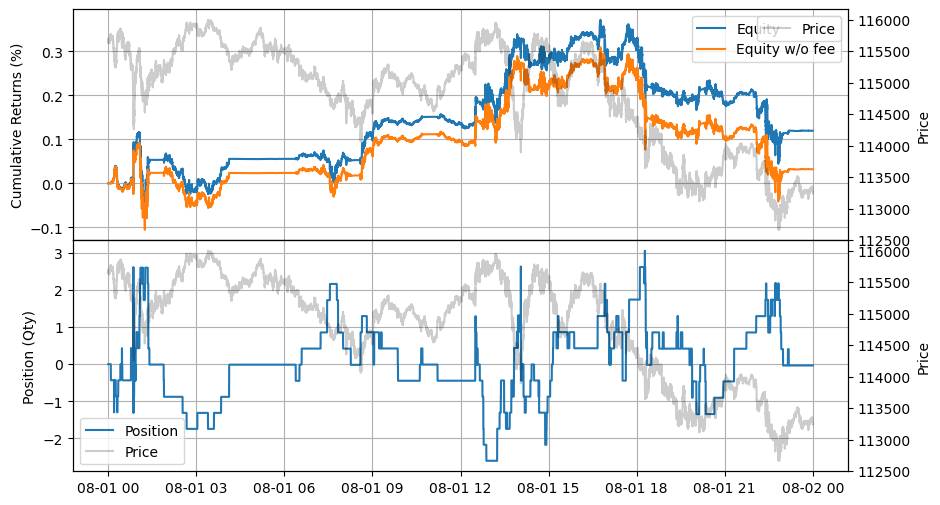

In [28]:
alpha = pl.DataFrame(np.zeros_like(rev_usdt))
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

The backtest results for the BTCUSDT spot return alpha.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,28.52991,42.995793,0.007582,0.003411,971.0,48.550618,2.222404,0.000156,1.0488e6


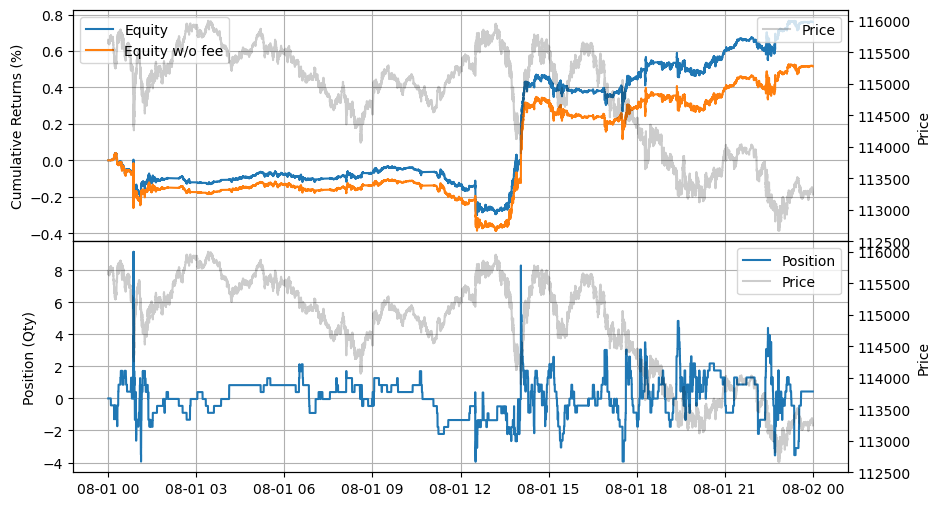

In [29]:
alpha = 1.0 * rev_usdt
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']

backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

For BTCFDUSD spot, the performance is weaker than BTCUSDT spot. Note, however, that this is only a one-day demonstration; comprehensive validation requires testing over a longer period.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,12.046548,17.388393,0.004711,0.007991,665.0,33.250376,0.589453,0.000142,1.0462e6


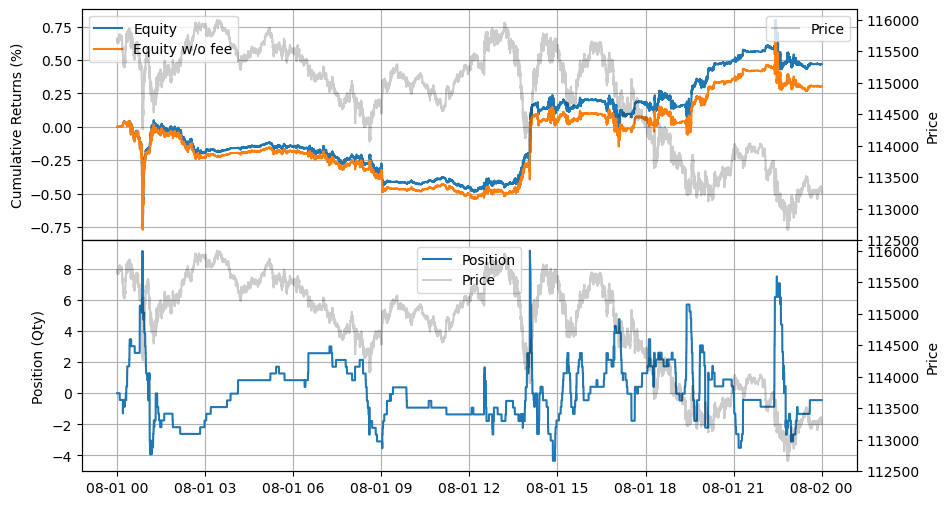

In [30]:
alpha = 1.0 * rev_fdusd
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

A reversion to the equally weighted market, as shown below, does not appear to be effective when applied independently.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,-21.303697,-29.843829,-0.024671,0.044545,8017.0,400.849028,-0.553835,-0.000062,1.0533e6


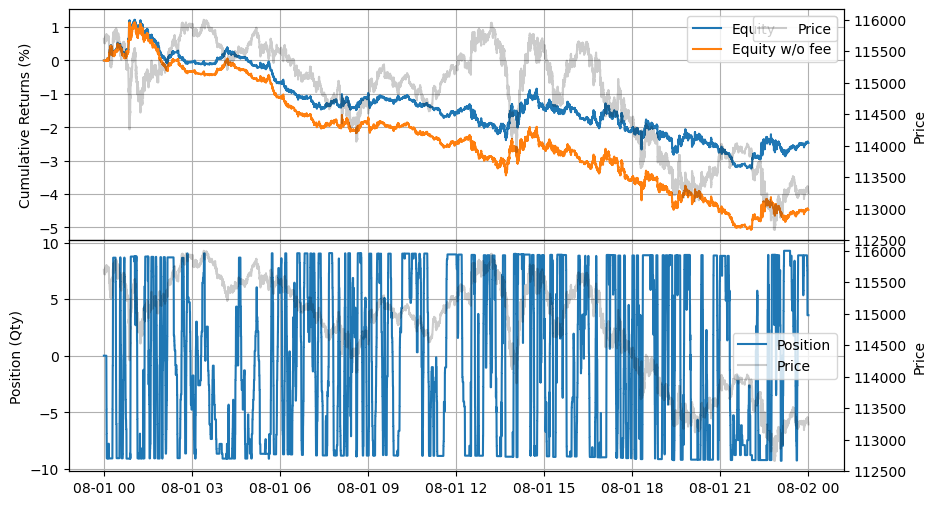

In [31]:
alpha = 1.0 * rev_mkt
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

Combining the two spot price return signals shows the better equity curve.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,23.227932,33.498231,0.012065,0.011553,1575.0,78.750637,1.044346,0.000153,1.0551e6


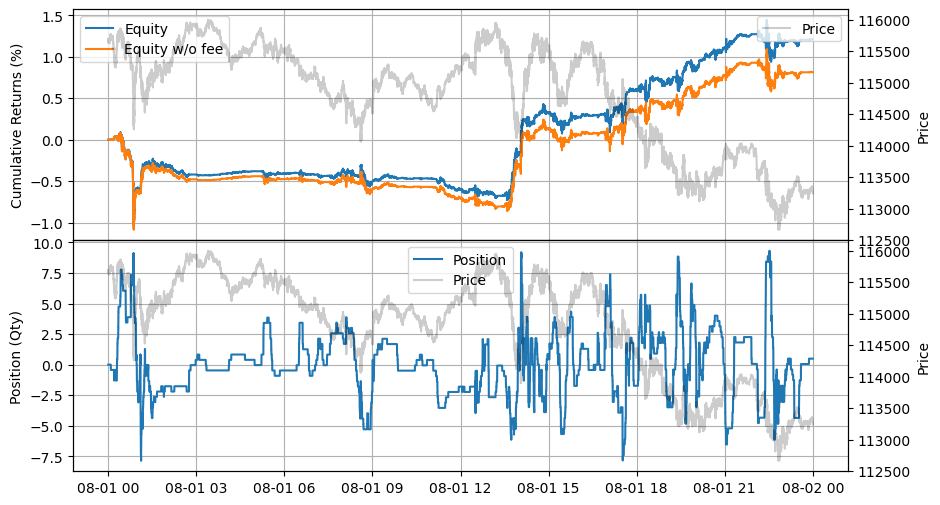

In [32]:
alpha = 1.0 * rev_usdt + 1.0 * rev_fdusd
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

VAMP at a depth range of 0.25% shows good performance.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,25.643825,36.901272,0.020504,0.00946,2297.0,114.853006,2.167534,0.000179,1.0995e6


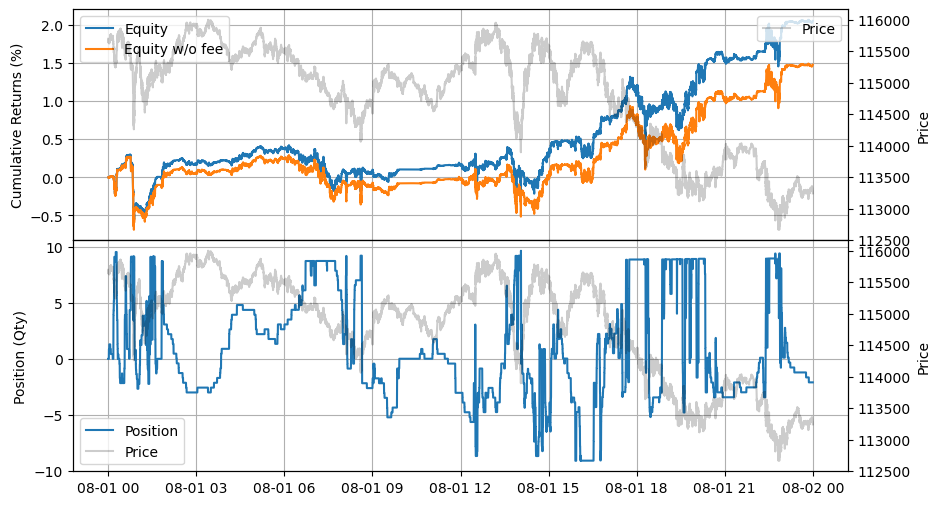

In [33]:
alpha = 1.0 * vamp_returns[:, :, 0]
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

VAMP at a depth range of 0.5% shows slightly positive performance.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,7.024184,9.921883,0.008218,0.014378,1317.0,65.846376,0.571563,0.000125,1.0534e6


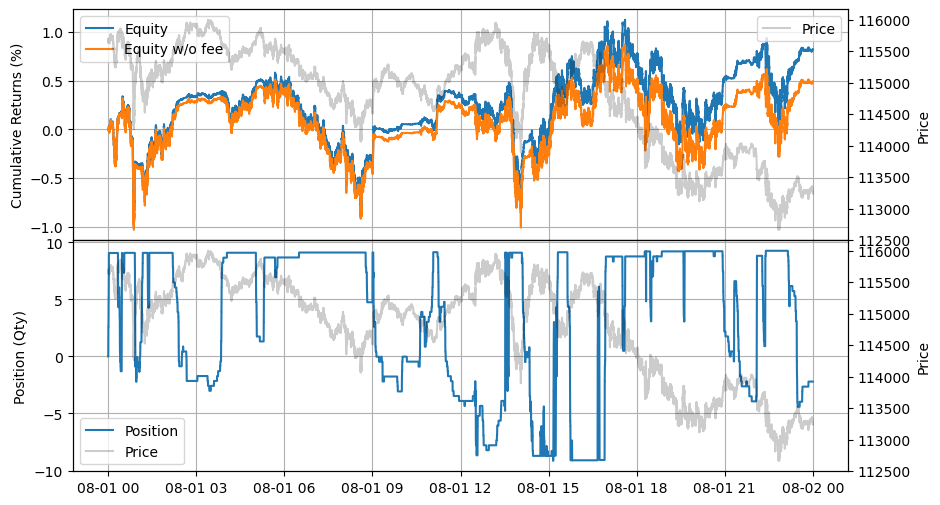

In [34]:
alpha = 1.0 * vamp_returns[:, :, 1]
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

In the case of Effective VAMP, the equity curve at a 0.5% depth range appears more stable than at a 0.25% depth range, in contrast to VAMP.

Effective VAMP at a depth range 0.25%

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,23.614107,34.202664,0.015358,0.008395,1449.0,72.452146,1.829365,0.000212,1.0604e6


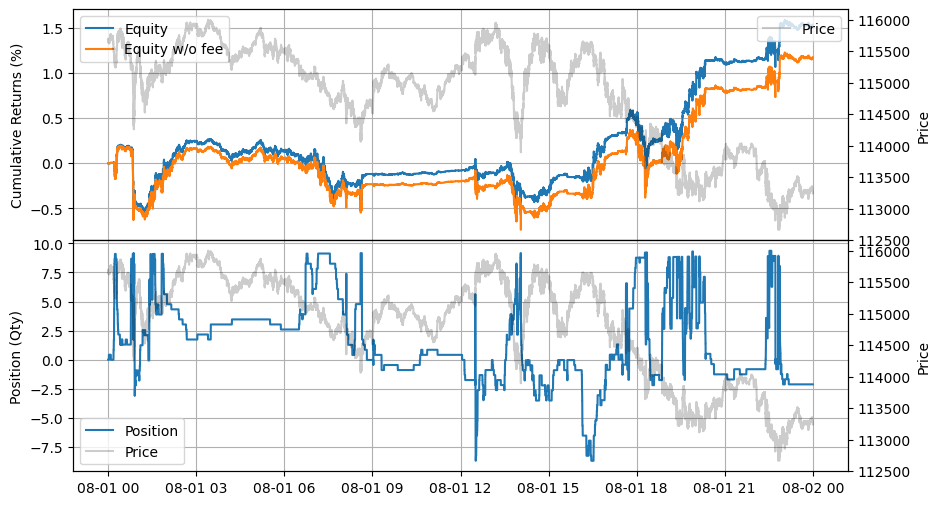

In [35]:
alpha = 1.0 * vamp_eff_returns[:, :, 0]
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

Effective VAMP at a depth range 0.50%

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,18.078537,25.716361,0.017605,0.012803,1466.0,73.301925,1.375036,0.00024,1.0549e6


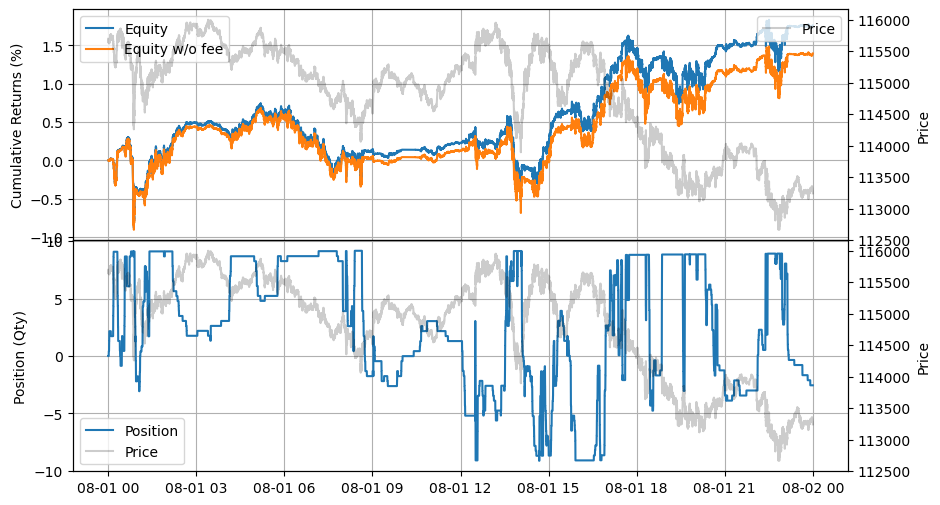

In [36]:
alpha = 1.0 * vamp_eff_returns[:, :, 1]
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

The [Market Making with Alpha - Order Book Imbalance](https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Order%20Book%20Imbalance.html) tutorial covered the standardized simple order book imbalance, and its effectiveness is reconfirmed within the current pricing framework. The parameters of the standardized order book imbalance are the same as those used in the [Market Making with Alpha - Order Book Imbalance](https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Order%20Book%20Imbalance.html) tutorial.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,21.421849,30.033065,0.015016,0.012204,1007.0,50.349009,1.230373,0.000298,1.0587e6


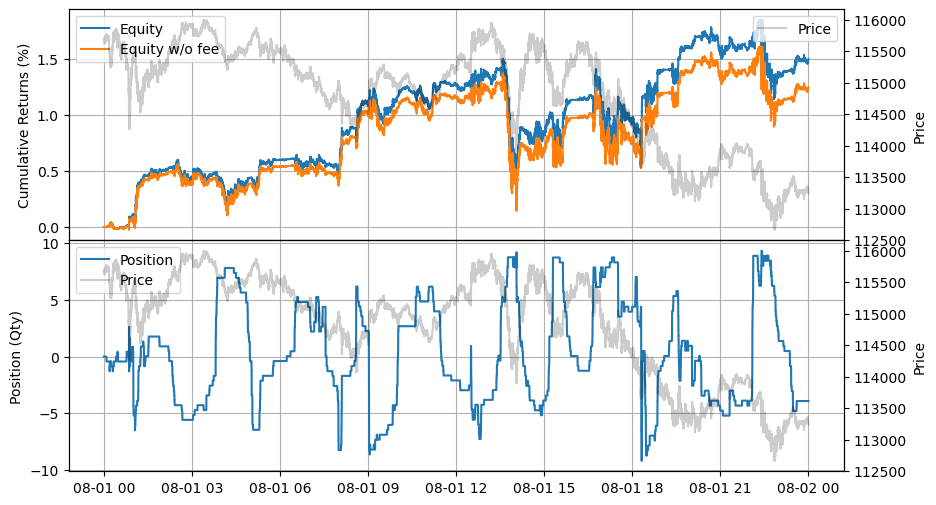

In [37]:
alpha = 1.0 * standardized_obi[:, :, 4]
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

The following illustrates the performance of the equally weighted linear sum of the signals.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,24.180597,34.395776,0.014064,0.007173,671.0,33.550337,1.960829,0.000419,1.0494e6


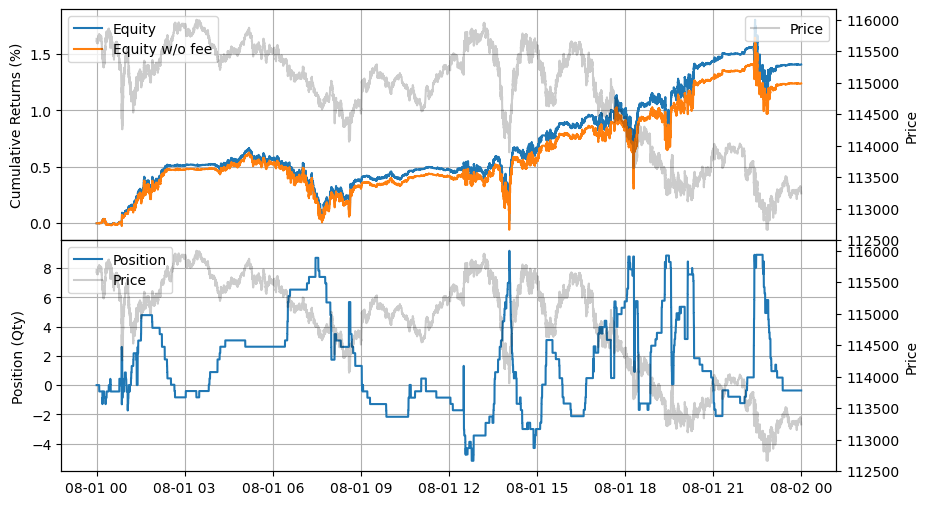

In [38]:
alpha = (1.0 * rev_usdt + 1.0 * rev_fdusd + 1.0 * vamp_eff_returns[:, :, 1] + 1.0 * standardized_obi[:, :, 4]) / 4
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

Optimizing the weights of signals may lead to better results, but the inclusion of multiple factors with adjusted weights inevitably heightens the risk of overfitting. In essence, pricing and forecasting amount to managing this risk, as the informational edge provided by each individual alpha is intrinsically limited and noisy.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,32.178054,46.365475,0.014301,0.005087,576.0,28.799652,2.811546,0.000497,1.0509e6


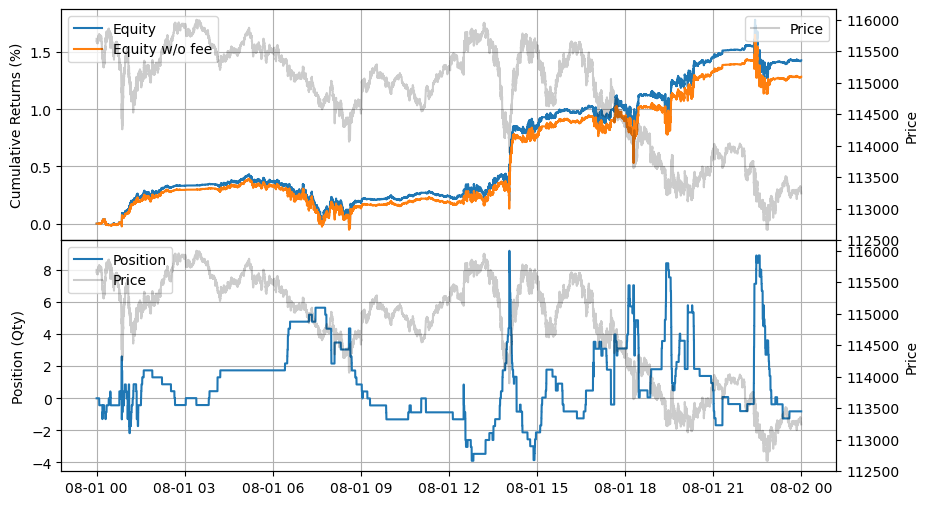

In [39]:
alpha = 0.3 * rev_usdt + 0.4 * rev_fdusd + 0.15 * vamp_eff_returns[:, :, 1] + 0.15 * standardized_obi[:, :, 4]
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

Even the reversion to the equal market, which does not improve results as an individual alpha, enhances performance when combined with multiple factors. However, the question remains: is this genuine or merely overfitting? A longer validation period is required to determine this.

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,49.861114,72.608402,0.039216,0.011771,2109.0,105.45063,3.331713,0.000372,1.0718e6


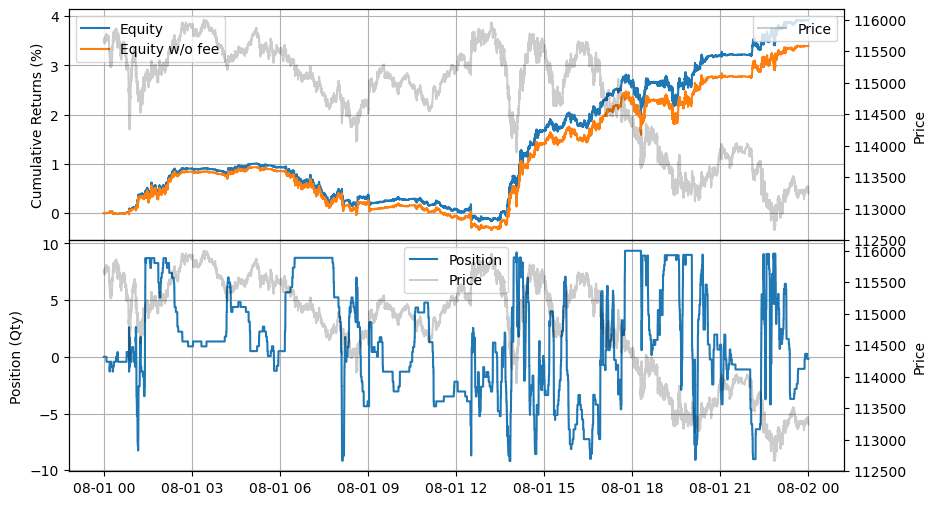

In [40]:
alpha = 0.1 * rev_mkt + 1.0 * rev_usdt + 1.0 * rev_fdusd + 0.5 * vamp_eff_returns[:, :, 1] + 0.1 * standardized_obi[:, :, 4]
alpha = pl.DataFrame(alpha).fill_nan(0)
alpha.columns = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'SOLUSDT', 'DOGEUSDT']
backtest('BTCUSDT', alpha['BTCUSDT'].to_numpy(), 0.00025)

An additional metric for assessing the signal is the information coefficient. As no explicit target forward return was defined, the IC is plotted over the forward return horizon.

In [41]:
def ic(symbol, alpha):
    ic = []
    k_ = np.arange(1, 36000, 100)
    for k in k_:
        df_alpha = alpha.with_columns(
            (df_futures[symbol].shift(-k) / df_futures[symbol] - 1).alias("fwd_ret")
        )
        
        # Drops last k rows (since they have no forward return)
        df_alpha = df_alpha.drop_nulls()
        
        # Computes IC
        ic.append(df_alpha.select(
            pl.corr(symbol, 'fwd_ret')
        ).item())
    plt.plot(k_ * 0.1 / 60, ic)
    plt.title('IC by Forward Return Horizon')
    plt.xlabel('Forward Return Horizon (min)')
    plt.ylabel('IC')
    plt.grid()

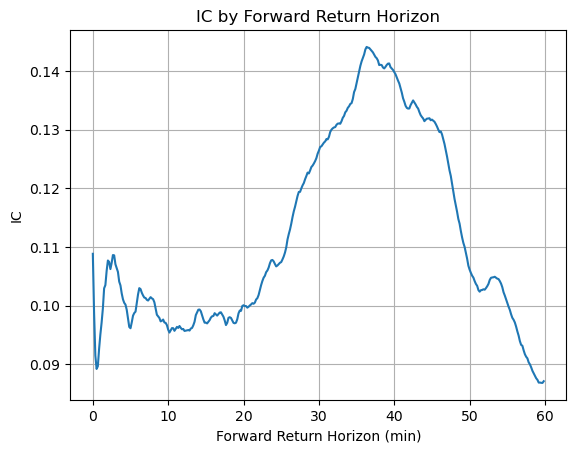

In [42]:
ic('BTCUSDT', alpha)

### ETHUSDT

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,16.907416,24.036481,0.022305,0.015962,3129.0,156.449781,1.397339,0.000143,1.0525e6


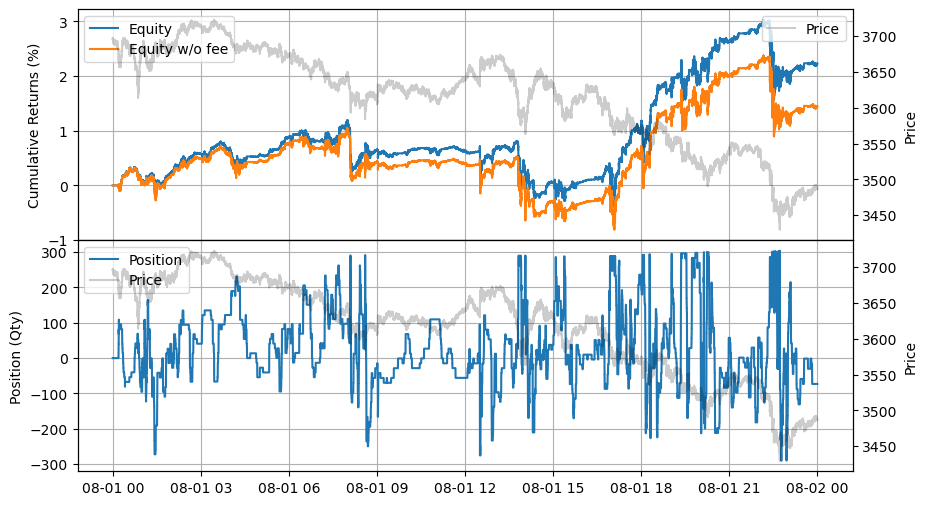

In [43]:
backtest('ETHUSDT', alpha['ETHUSDT'].to_numpy(), 0.0005)

### XRPUSDT

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,13.239982,19.143894,0.015689,0.020004,2619.0,130.950162,0.784284,0.00012,1.0512e6


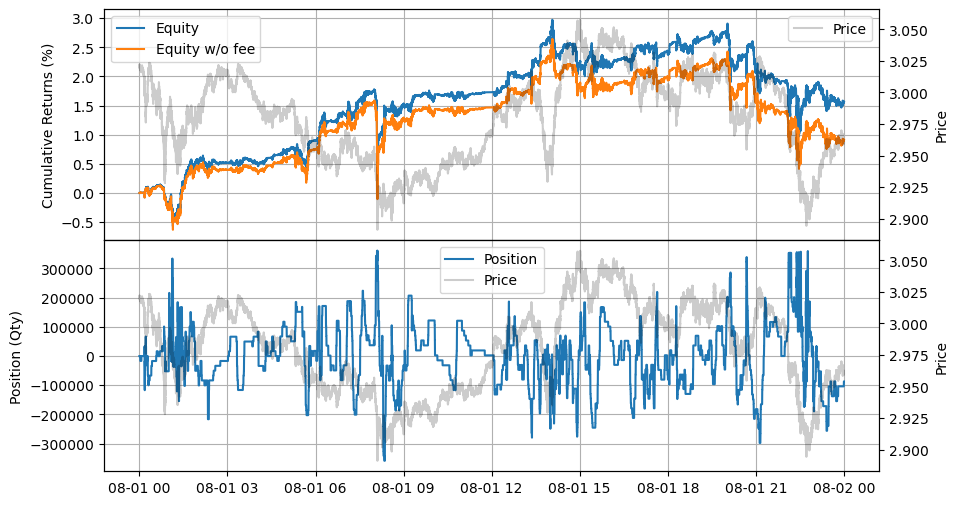

In [44]:
backtest('XRPUSDT', alpha['XRPUSDT'].to_numpy(), 0.0005)

### SOLUSDT

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,1.833742,2.591809,0.0025,0.021056,1921.0,96.049416,0.118718,0.000026,1.0528e6


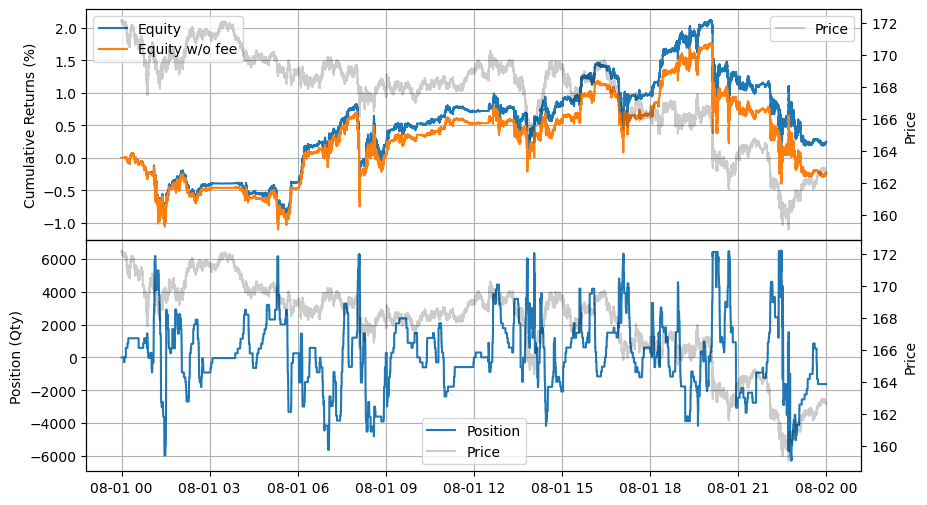

In [45]:
backtest('SOLUSDT', alpha['SOLUSDT'].to_numpy(), 0.0005)

### DOGEUSDT

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,-12.423814,-17.422319,-0.024179,0.064173,3559.0,177.949679,-0.376771,-0.000136,1.0568e6


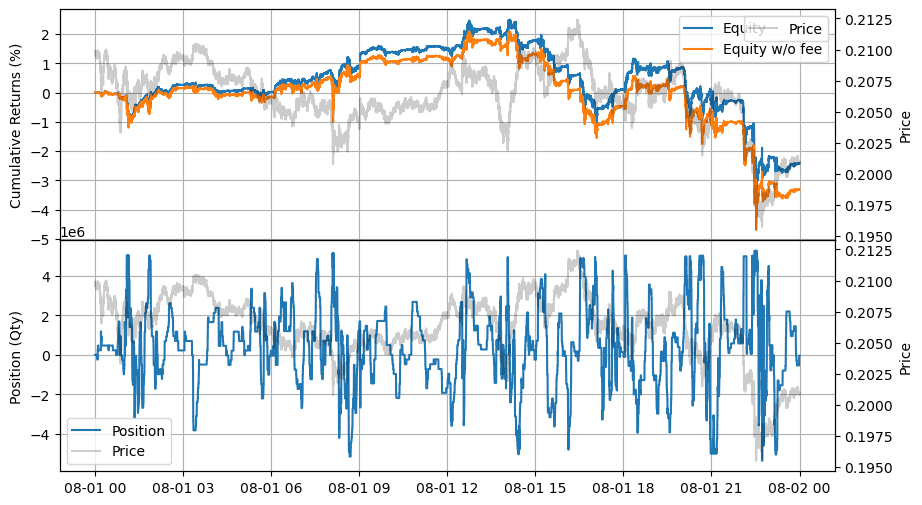

In [46]:
backtest('DOGEUSDT', alpha['DOGEUSDT'].to_numpy(), 0.0005)

### ETHUSDT

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,21.51677,30.388456,0.024653,0.014365,1964.0,98.199312,1.716209,0.000251,1.0958e6


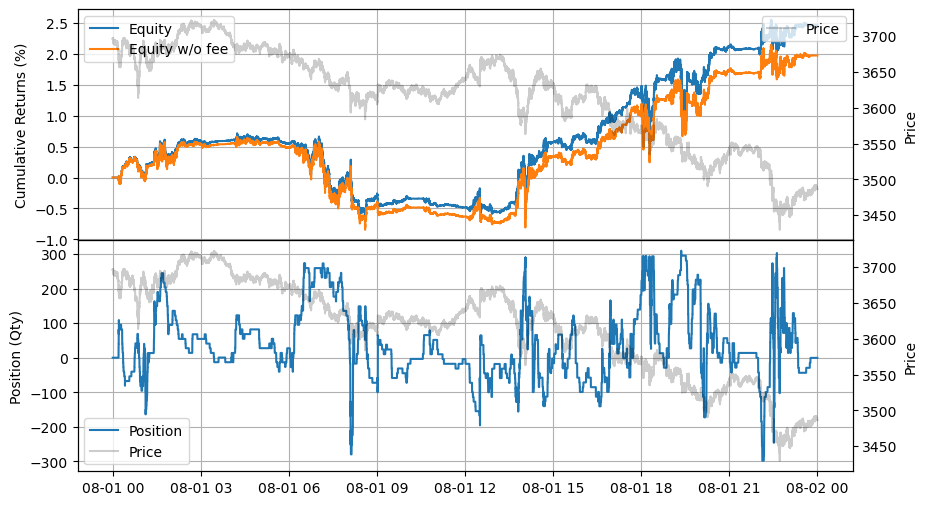

In [47]:
backtest('ETHUSDT', alpha['BTCUSDT'].to_numpy(), 0.0005)

### XRPUSDT

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,28.746574,40.69477,0.040694,0.017157,1721.0,86.04976,2.371859,0.000473,1.0526e6


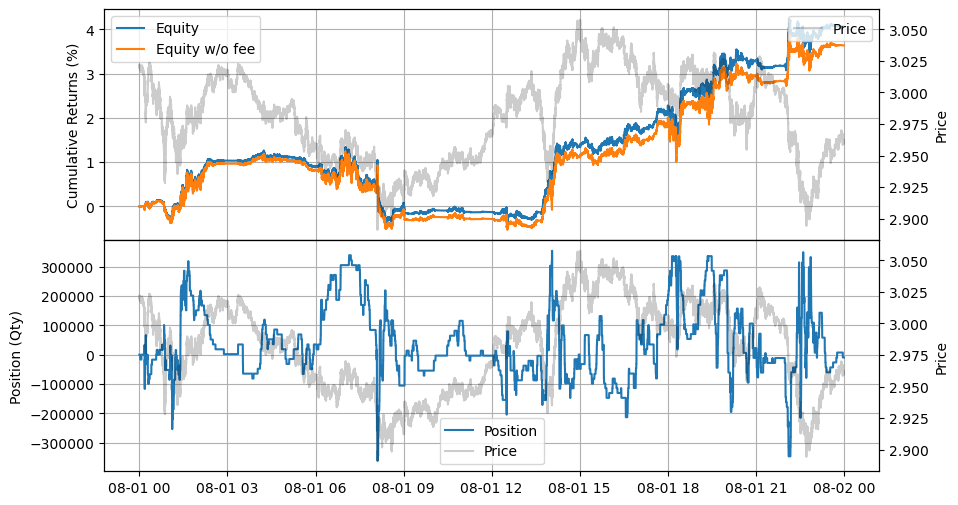

In [48]:
backtest('XRPUSDT', alpha['BTCUSDT'].to_numpy(), 0.0005)

### SOLUSDT

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,24.081415,33.788855,0.029743,0.015525,1334.0,66.698639,1.915799,0.000446,1.0537e6


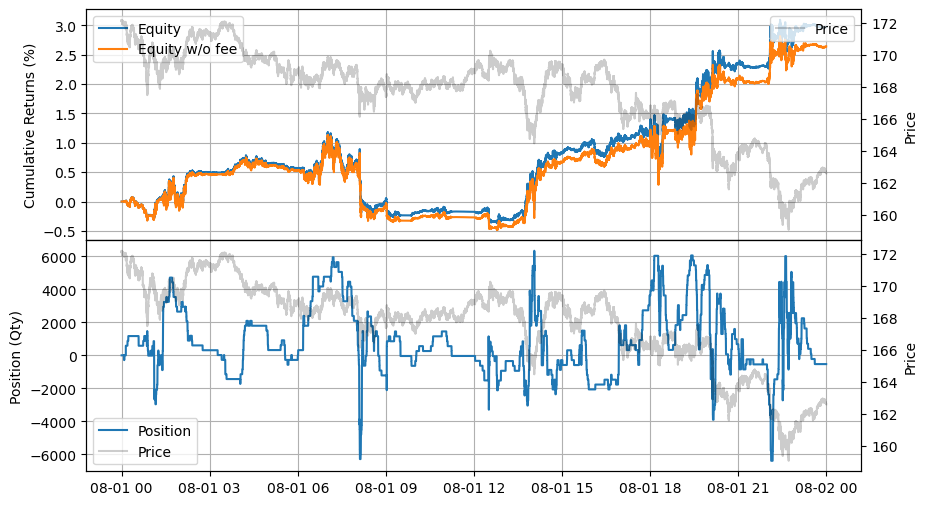

In [49]:
backtest('SOLUSDT', alpha['BTCUSDT'].to_numpy(), 0.0005)

### DOGEUSDT

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,19.840674,27.900083,0.033406,0.015131,2322.0,116.097934,2.207866,0.000288,1.0536e6


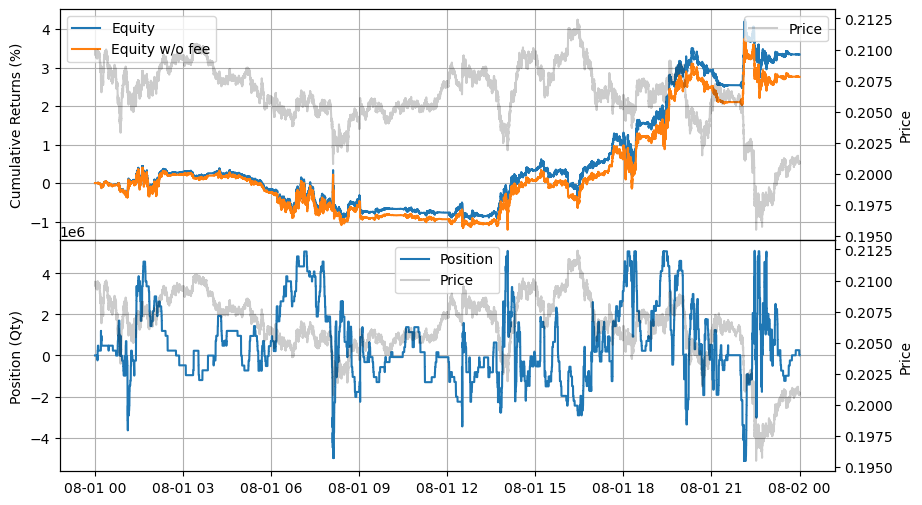

In [50]:
backtest('DOGEUSDT', alpha['BTCUSDT'].to_numpy(), 0.0005)

## Backtesting over a longer period
to be continued...